In [1]:
import pycigar
from pycigar.utils.registry import make_create_env
from pycigar.utils.input_parser import input_parser
from pycigar.utils.logging import logger
from pycigar.utils.output import plot_new

from ray.tune.registry import register_env

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import json
from pathlib import Path
from ray.rllib.models.tf.tf_action_dist import DiagGaussian
from ray.rllib.models.catalog import ModelCatalog
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Env config

In [2]:
def adjust_defaults(sim_params):
    for node in sim_params['scenario_config']['nodes']:
        for d in node['devices']:
            d['adversary_controller'] = 'unbalanced_fixed_controller'
            name = d['name']
            c = np.array(d['custom_device_configs']['default_control_setting'])
            if name.endswith('a'):
                c = c #- 0.02
            elif name.endswith('b'):
                c = c #+ 0.02
            elif name.endswith('c'):
                c = c #- 0.015
            d['custom_device_configs']['default_control_setting'] = c
    
    sim_params['simulation_config']['custom_configs']['solution_control_mode'] = 2

            
def set_hack_percent(sim_params, hack=0.45):
    for node in sim_params['scenario_config']['nodes']:
        for d in node['devices']:
            d['hack'] = [250, hack, 500]
    
def get_config(env_name='CentralControlPhaseSpecificContinuousPVInverterEnv'):
    pycigar_params = {'exp_tag': 'cooperative_multiagent_ppo',
                      'env_name': env_name,
                      'simulator': 'opendss'}
    create_env, env_name = make_create_env(pycigar_params, version=0)
    register_env(env_name, create_env)

    misc_inputs_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/misc_inputs.csv"
    dss_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/ieee37.dss"
    load_solar_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/load_solar_data.csv"
    breakpoints_path = pycigar.DATA_DIR + "/ieee37busdata_regulator_attack/breakpoints.csv"
    sim_params = input_parser(misc_inputs_path, dss_path, load_solar_path, breakpoints_path)
    
    eval_start = 100
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]
    sim_params['scenario_config']['multi_config'] = False
    del sim_params['attack_randomization']
    adjust_defaults(sim_params)
    
    return create_env, sim_params

## Util: eval policy checkpoint

In [3]:
def eval_baseline(eval_start=100, hack=0.45):
    create_env, sim_params = get_config('CentralControlPhaseSpecificContinuousPVInverterEnv')
    set_hack_percent(sim_params, hack)
    result_dict = {'stds': []}
    
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]
    test_env = create_env(sim_params)

    done = False
    obs = test_env.reset()
    obs = obs.tolist()
    while not done:
        obs, r, done, _ = test_env.step(np.array([0, 0, 0]))
        obs = obs.tolist()

    Logger = logger()
    f = plot_new(Logger.log_dict, Logger.custom_metrics, None, unbalance=True)
    result_dict['figure'] = f
    plt.close(f)
    inv = [k for k in Logger.log_dict if k.startswith('inverter_s701') or k.startswith('inverter_s728')][0]

    result_dict['u_sum'] = sum(Logger.log_dict[inv]['u'])
    return result_dict

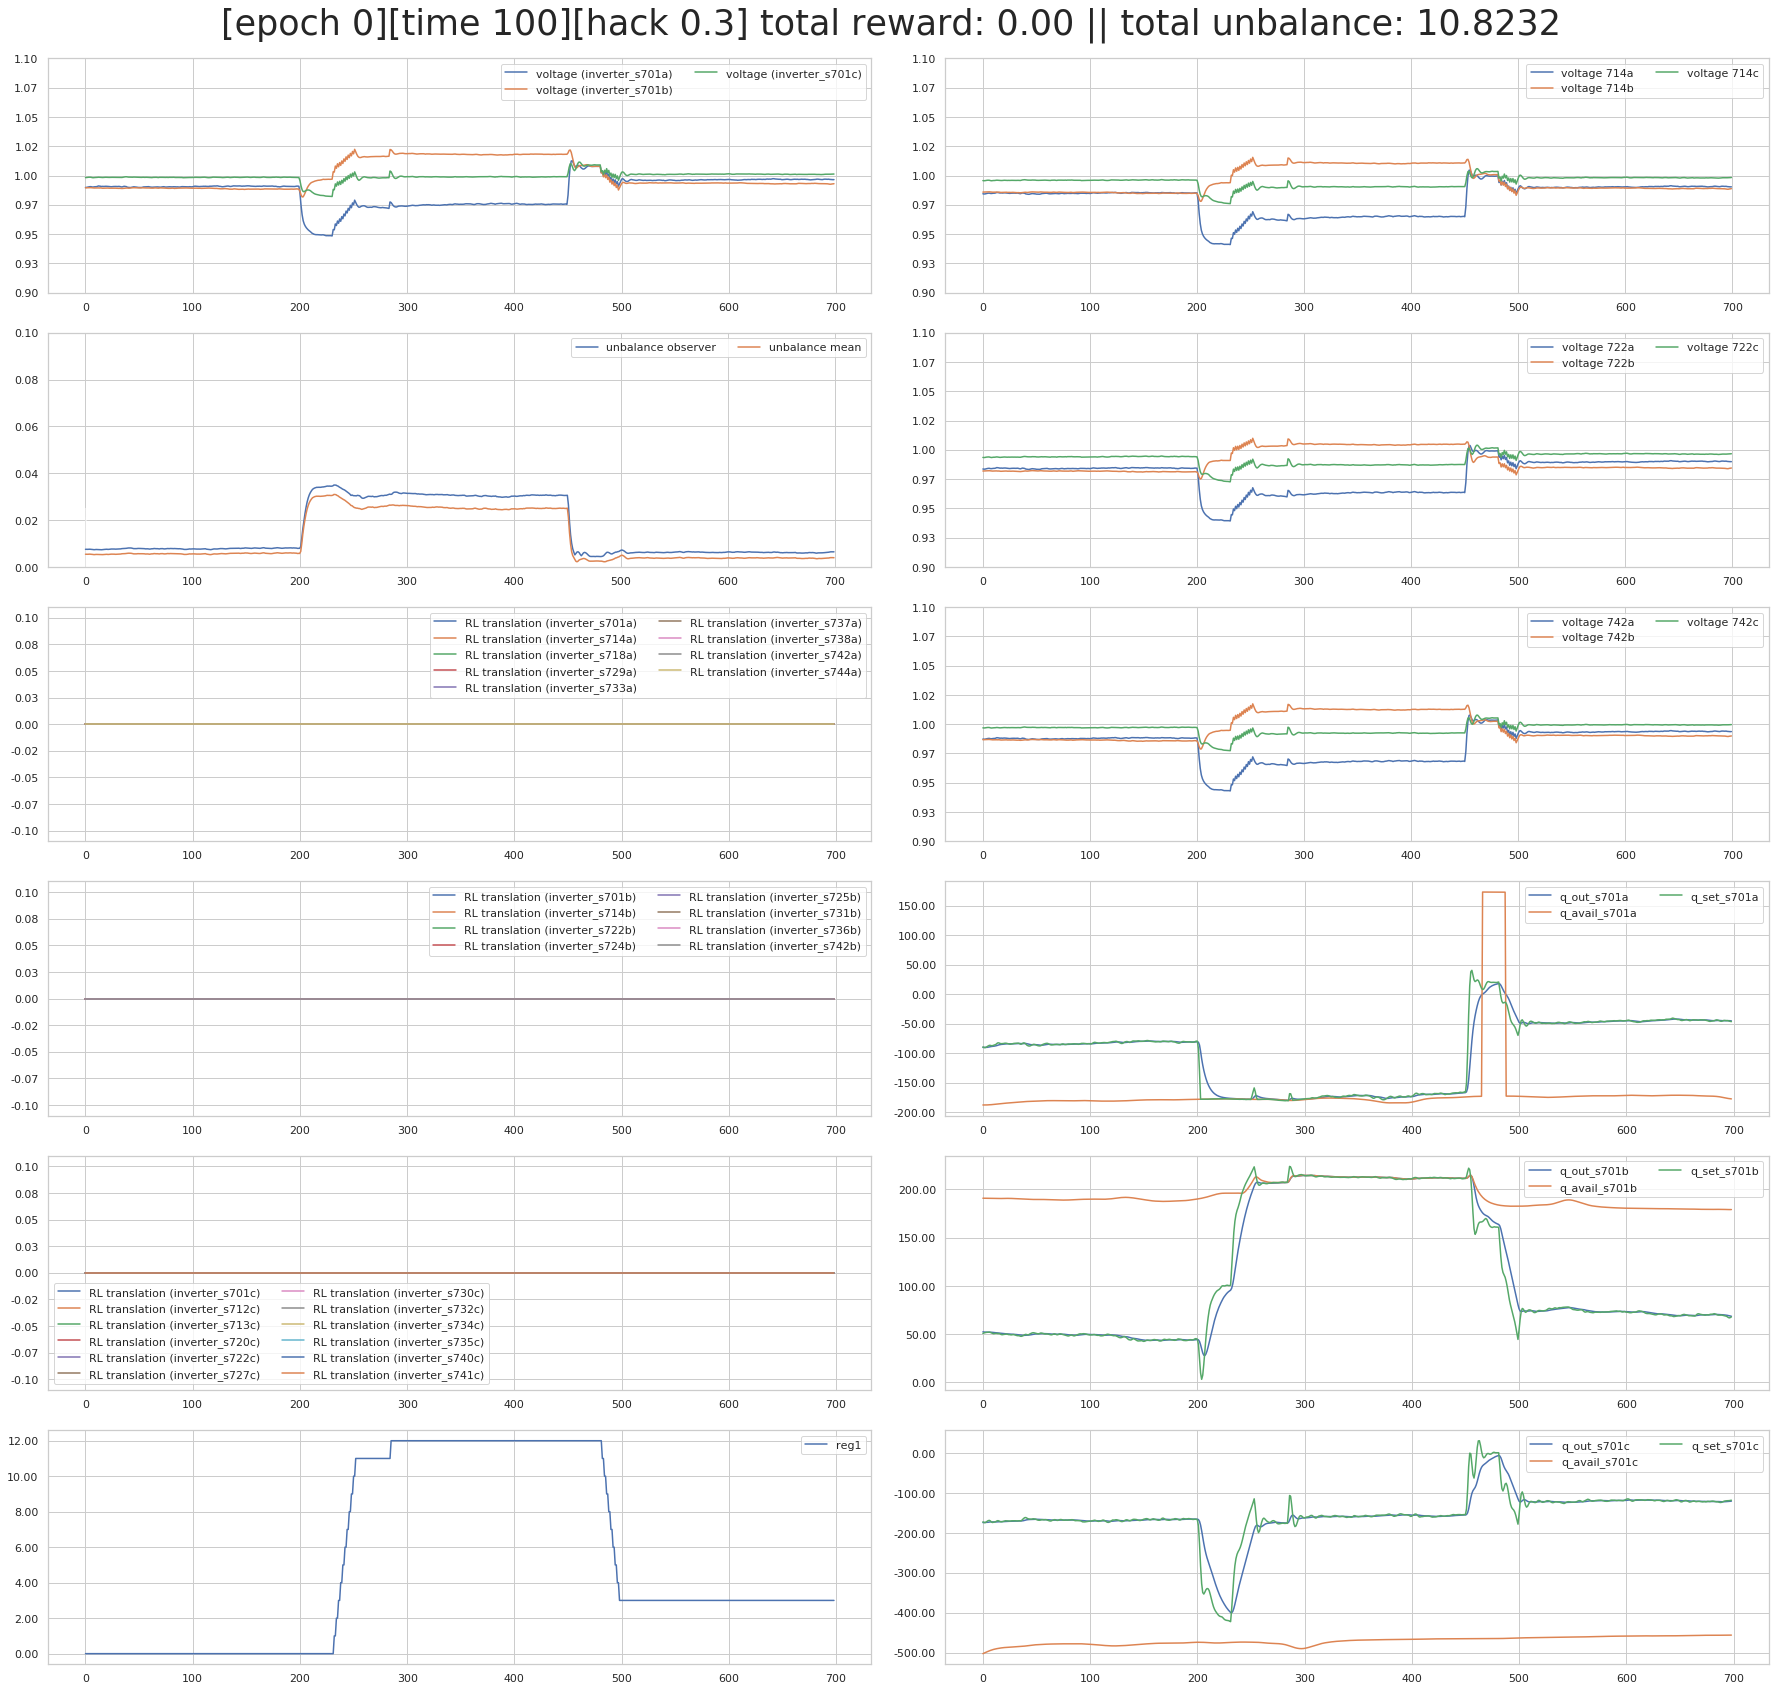

In [4]:
res = eval_baseline(eval_start=100, hack=0.3)
res['figure']

In [5]:
#ls = []
#for i in logger().log_dict['v_metrics'].keys():
#    ls.append(logger().log_dict['v_metrics'][i])
logger().log_dict['v_metrics']['51'][0]

{'sourcebus': [1.019996272392541, 1.0199960504409478, 1.0199973680103007],
 '799': [0.9959161253800515, 0.9942790787337914, 1.0029886178333145],
 '701': [0.9901341453121298, 0.9895730200463232, 0.9983149173285085],
 '702': [0.9877456885998984, 0.9879247601661733, 0.9968679992063114],
 '705': [0.987500147605666, 0.9873367641279476, 0.9971158518098069],
 '713': [0.9863745557640676, 0.9871064962720655, 0.9964132844257398],
 '703': [0.9866407682079935, 0.9877308591580852, 0.9954222093350074],
 '727': [0.9862820227079244, 0.987123980012585, 0.9951304985851671],
 '730': [0.98595530620299, 0.9878204950617615, 0.9940941194724697],
 '704': [0.9848310914342719, 0.9859252972986058, 0.9955754887896581],
 '714': [0.9845679616206389, 0.9859405923422124, 0.9955714793190014],
 '720': [0.984107339157241, 0.9843688507310594, 0.9943492324381673],
 '742': [0.9874700860501933, 0.9868661811452039, 0.9968497283786912],
 '712': [0.9873755737345871, 0.9873367927660701, 0.9974641272218847],
 '706': [0.984102709

In [6]:
def eval_dir_discrete(best_dir, eval_start=100, hack=0.4):
    create_env, sim_params = get_config('CentralControlPhaseSpecificPVInverterEnv')
    set_hack_percent(sim_params, hack)
    result_dict = {}
    sim_params['scenario_config']['start_end_time'] = [eval_start, eval_start + 750]
    sim_params['env_config']['sims_per_step'] = 35
    sim_params['is_disable_y'] = True

    test_env = create_env(sim_params)
    action_dist, _ = ModelCatalog.get_action_dist(
        test_env.action_space, config={}, dist_type=None, framework='tf')
    #assert isinstance(action_dist, DiagGaussian.__class__), 'For now only continuous gaussian action are supported'
    done = False
    obs = test_env.reset()
    obs = obs.tolist()
    count = 0
    while not done:
        out = infer(
            prev_reward=tf.constant([0.], tf.float32),
            observations=tf.constant([obs], tf.float32),
            is_training=tf.constant(False),
            seq_lens=tf.constant([0], tf.int32),
            prev_action=tf.constant([0], tf.int64)
        )['action_dist_inputs'].numpy()
        dist = action_dist(inputs=out, model=None)
        #act = dist.deterministic_sample().numpy().batches
        act = np.array(dist.deterministic_sample()).flatten()

        #if 6 < count < 13:
        #    act[0] = act[2] = 16
        #print(act)
        obs, r, done, _ = test_env.step(act)
        obs = obs.tolist()
        count += 1

    print('done')
    Logger = logger()
    f = plot_new(Logger.log_dict, Logger.custom_metrics, 0, unbalance=True)
    result_dict['figure'] = f
    result_dict['log_dict'] = Logger.log_dict
    plt.close(f)

    return result_dict

done


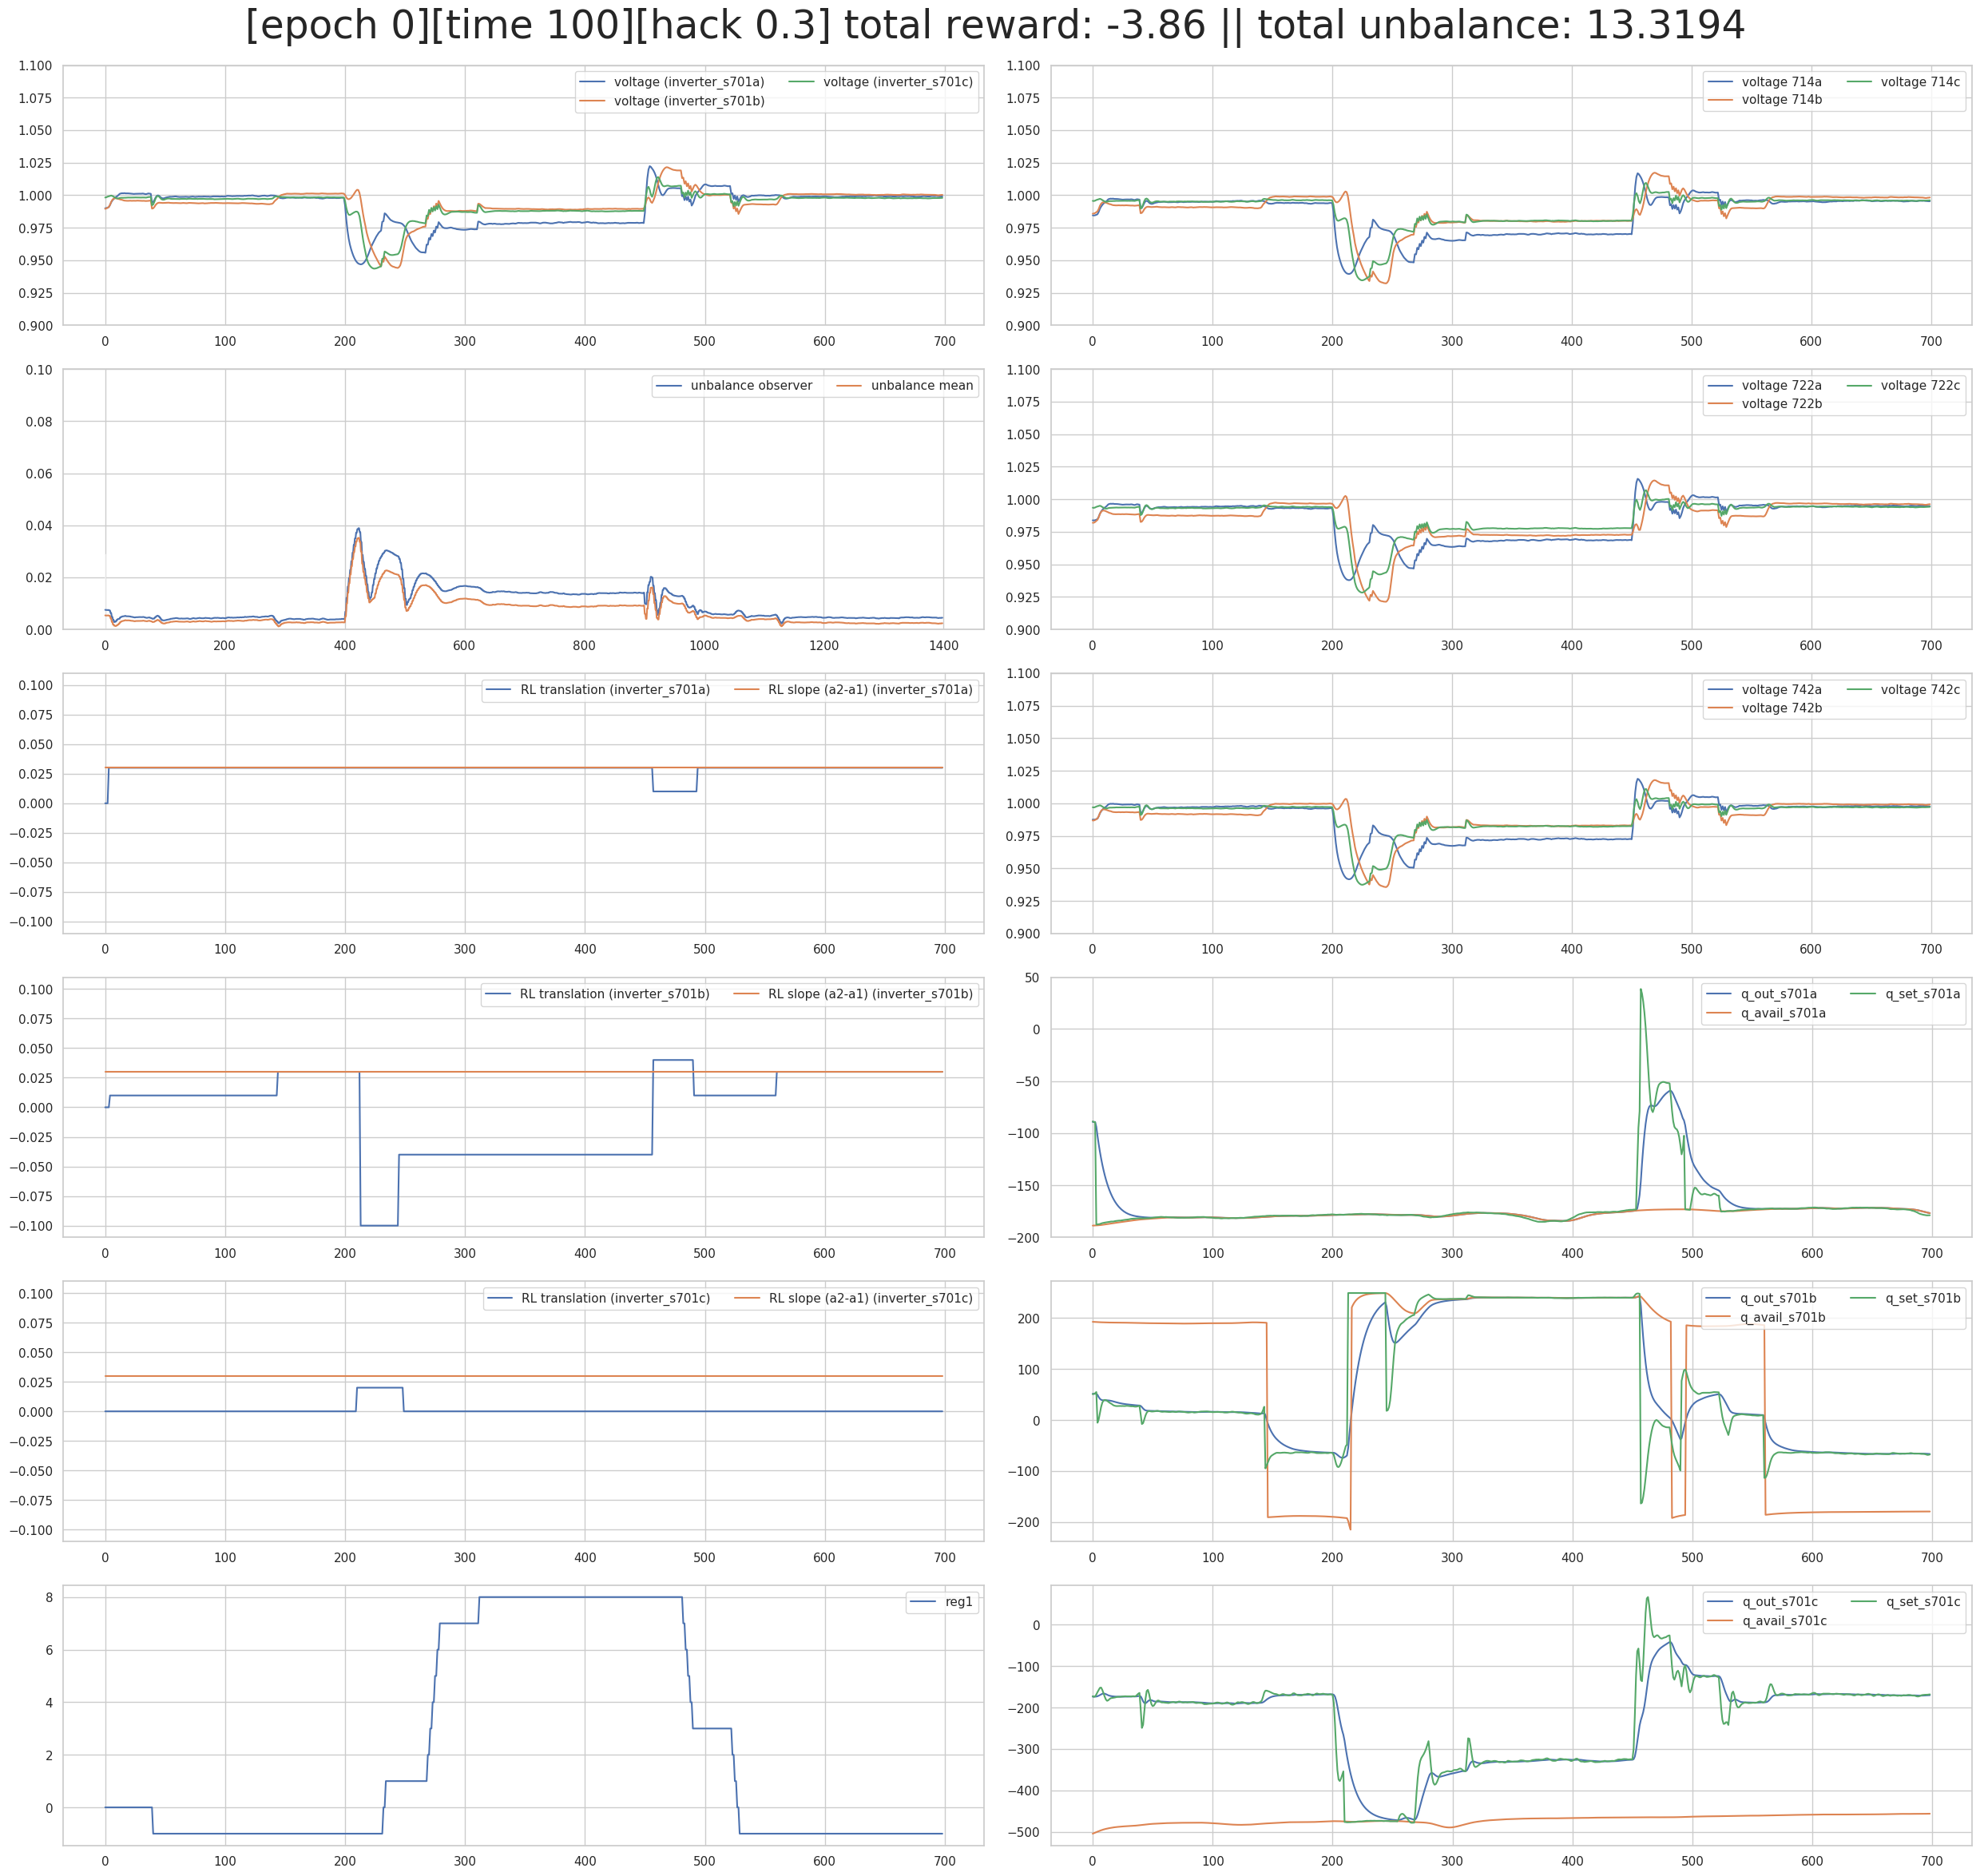

In [8]:
%matplotlib agg
%matplotlib agg

#best_dir = Path('/home/toanngo/results_discrete_eval_30_random_reg_original_add_voltage_scale_2000_new_eval/main/run_train/run_train_0_P=100,M=50000,N=50,P=100_2020-08-22_21-43-376e6ljdl7/eval/1000/')

#current policy --- 1st Sept 2020
#best_dir = Path('/home/toanngo/results_discrete_eval_30_random_reg_original_add_voltage_scale_2000_new_eval_avg_u/main/run_train/run_train_0_P=60,M=50000,N=50,P=60_2020-08-27_22-18-556y29xvyg/eval/560/')
#policy = tf.saved_model.load(str(best_dir / f'policy_560'))

best_dir = Path('/home/toanngo/results_discrete_eval_30_random_reg_original_add_voltage_scale_2000_new_eval_avg_u_T_tune_lower/main/run_train/run_train_0_T=2,M=50000,N=50,P=60_2020-08-31_01-49-16wt63trc5/best/reward_sum/')
policy = tf.saved_model.load(str(best_dir / f'policy_760'))

infer = policy.signatures['serving_default']
    
res = eval_dir_discrete(best_dir, 100, 0.3)
res['figure']

In [7]:
from pycigar.utils.logging import logger

def get_translation_and_slope(a_val, init_a):
    points = np.array(a_val)
    slope = points[:, 1] - points[:, 0]
    translation = points[:, 2] - init_a[2]
    return translation, slope

log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

ta, _ = get_translation_and_slope(
                    log_dict['inverter_s701a']['control_setting'], custom_metrics['init_control_settings']['inverter_s701a']
                )
tb, _ = get_translation_and_slope(
                    log_dict['inverter_s701b']['control_setting'], custom_metrics['init_control_settings']['inverter_s701b']
                )
tc, _ = get_translation_and_slope(
                    log_dict['inverter_s701c']['control_setting'], custom_metrics['init_control_settings']['inverter_s701c']
                )
tall, _ = get_translation_and_slope(
                    log_dict['inverter_s728']['control_setting'], custom_metrics['init_control_settings']['inverter_s728']
                )

qouta = log_dict['inverter_s701a']['q_out']
qoutb = log_dict['inverter_s701b']['q_out']
qoutc = log_dict['inverter_s701c']['q_out']

qavaila = log_dict['inverter_s701a']['q_avail_real']
qavailb = log_dict['inverter_s701b']['q_avail_real']
qavailc = log_dict['inverter_s701c']['q_avail_real']

va = log_dict['s701a']['voltage']
vb = log_dict['s701b']['voltage']
vc = log_dict['s701c']['voltage']
u = log_dict['inverter_s701c']['u']
reg = log_dict['reg1']['tap_number']

import pandas as pd
df = pd.DataFrame({'va': va, 'vb': vb, 'vc': vc, 't_a': ta, 't_b': tb, 't_c': tc, 't_all': tall, 'u': u, 'ht_a': ta, 'ht_b': tb, 'ht_c': tc, 'ht_all': tall, 'reg': reg, 'qout_a': qouta, 'qout_b': qoutb, 'qout_c': qoutc, 'qavail_a': qavaila,  'qavail_b': qavailb,  'qavail_c': qavailc})
#df.to_csv('baseline_h30_t100_test.csv', sep=',')
#df.to_csv('discrete_h30_t100_test.csv', sep=',')
#df.to_csv('discrete_h40_t100_test.csv', sep=',')
#df.to_csv('discrete_h40_t11000_test.csv', sep=',')

In [7]:
################ check out the imbalance in other buses ##################

In [ ]:
%matplotlib agg
%matplotlib agg

#best_dir = Path('/home/toanngo/results_discrete_eval_30_random_reg_original_add_voltage_scale_2000_new_eval/main/run_train/run_train_0_P=100,M=50000,N=50,P=100_2020-08-22_21-43-376e6ljdl7/eval/1000/')

#current policy --- 1st Sept 2020
#best_dir = Path('/home/toanngo/results_discrete_eval_30_random_reg_original_add_voltage_scale_2000_new_eval_avg_u/main/run_train/run_train_0_P=60,M=50000,N=50,P=60_2020-08-27_22-18-556y29xvyg/eval/560/')
#policy = tf.saved_model.load(str(best_dir / f'policy_560'))

best_dir = Path('/home/toanngo/results_discrete_eval_30_random_reg_original_add_voltage_scale_2000_new_eval_avg_u_T_tune_lower/main/run_train/run_train_0_T=2,M=50000,N=50,P=60_2020-08-31_01-49-16wt63trc5/best/reward_sum/')
policy = tf.saved_model.load(str(best_dir / f'policy_760'))

infer = policy.signatures['serving_default']
    
res = eval_dir_discrete(best_dir, 100, 0.3)
res['figure']

In [8]:
res['log_dict'].keys()

dict_keys(['component_observation', 'inverter_s701a', 'adversary_inverter_s701a', 'inverter_s701b', 'adversary_inverter_s701b', 'inverter_s701c', 'adversary_inverter_s701c', 'inverter_s712c', 'adversary_inverter_s712c', 'inverter_s713c', 'adversary_inverter_s713c', 'inverter_s714a', 'adversary_inverter_s714a', 'inverter_s714b', 'adversary_inverter_s714b', 'inverter_s718a', 'adversary_inverter_s718a', 'inverter_s720c', 'adversary_inverter_s720c', 'inverter_s722b', 'adversary_inverter_s722b', 'inverter_s722c', 'adversary_inverter_s722c', 'inverter_s724b', 'adversary_inverter_s724b', 'inverter_s725b', 'adversary_inverter_s725b', 'inverter_s727c', 'adversary_inverter_s727c', 'inverter_s728', 'adversary_inverter_s728', 'inverter_s729a', 'adversary_inverter_s729a', 'inverter_s730c', 'adversary_inverter_s730c', 'inverter_s731b', 'adversary_inverter_s731b', 'inverter_s732c', 'adversary_inverter_s732c', 'inverter_s733a', 'adversary_inverter_s733a', 'inverter_s734c', 'adversary_inverter_s734c', 

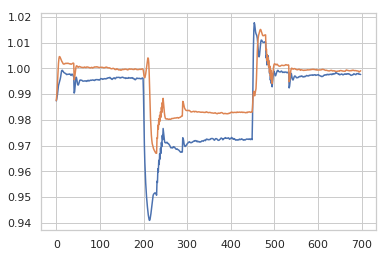

In [19]:
%matplotlib inline
node_714 = ['s714a', 's714b']
node_722 = ['s722b', 's722c']
node_742 = ['s742a', 's742b']
node_701 = ['s701a', 's701b', 's701c']
for node in node_742:
    plt.plot(res['log_dict'][node]['voltage'])
plt.show()

In [14]:
a = None
if a:
    print('ahihi')

In [15]:
import numpy as np
a = np.array([1,2,3,4])

In [16]:
np.mean(a)

2.5

In [5]:
from pycigar.utils.logging import logger
def get_translation_and_slope(a_val, init_a):
    points = np.array(a_val)
    slope = points[:, 1] - points[:, 0]
    translation = points[:, 2] - init_a[2]
    return translation, slope

log_dict = logger().log_dict
custom_metrics = logger().custom_metrics

ta_all = []
tb_all = []
tc_all = []

qouta_all = []
qoutb_all = []
qoutc_all = []
for k, v in enumerate(log_dict):
    if v.startswith('inverter_') and v.endswith('a'):
        ta, _ = get_translation_and_slope(log_dict[v]['control_setting'], custom_metrics['init_control_settings'][v])
        ta_all.append(ta)
        qouta_all.append(log_dict[v]['q_out'])
    if v.startswith('inverter_') and v.endswith('b'):
        tb, _ = get_translation_and_slope(log_dict[v]['control_setting'], custom_metrics['init_control_settings'][v])
        tb_all.append(tb)
        qoutb_all.append(log_dict[v]['q_out'])
    if v.startswith('inverter_') and v.endswith('c'):
        tc, _ = get_translation_and_slope(log_dict[v]['control_setting'], custom_metrics['init_control_settings'][v])
        tc_all.append(tc)
        qoutc_all.append(log_dict[v]['q_out'])

ta_all = np.array(ta_all).T
tb_all = np.array(tb_all).T
tc_all = np.array(tc_all).T

qouta_all = np.array(qouta_all).T
qoutb_all = np.array(qoutb_all).T
qoutc_all = np.array(qoutc_all).T
qouta_mean = np.mean(qouta_all, axis=1)
qoutb_mean = np.mean(qoutb_all, axis=1)
qoutc_mean = np.mean(qoutc_all, axis=1)
qouta_std = np.std(qouta_all, axis=1)
qoutb_std = np.std(qoutb_all, axis=1)
qoutc_std = np.std(qoutc_all, axis=1)

va = log_dict['s701a']['voltage']
vb = log_dict['s701b']['voltage']
vc = log_dict['s701c']['voltage']

u_worst = log_dict['u_metrics']['u_worst'][1:]
u_mean = log_dict['u_metrics']['u_mean'][1:]
u_std = log_dict['u_metrics']['u_std'][1:]
reg = log_dict['reg1']['tap_number']
import pandas as pd
df = {'va': va, 'vb': vb, 'vc': vc, 'u_worst': u_worst, 'u_mean': u_mean, 'u_std': u_std, 'reg': reg}
for i in range(ta_all.shape[1]):
    df['ta_' + str(i)] = ta_all[:, i]
for i in range(tb_all.shape[1]):
    df['tb_' + str(i)] = tb_all[:, i]
for i in range(tc_all.shape[1]):
    df['tc_' + str(i)] = tc_all[:, i]

df['qouta_mean'] = qouta_mean
df['qoutb_mean'] = qoutb_mean
df['qoutc_mean'] = qoutc_mean
df['qouta_std'] = qouta_std
df['qoutb_std'] = qoutb_std
df['qoutc_std'] = qoutc_std

df['qouta_total'] = np.sum(qouta_all, axis=1)
df['qoutb_total'] = np.sum(qoutb_all, axis=1)
df['qoutc_total'] = np.sum(qoutc_all, axis=1)

df = pd.DataFrame(df)
df.to_csv('baseline_h30_t100_test_distributed.csv', sep=',')
#df.to_csv('discrete_h30_t100_test_distributed.csv', sep=',')
#df.to_csv('discrete_h40_t100_test_distributed.csv', sep=',')
#df.to_csv('discrete_h40_t11000_test_distributed.csv', sep=',')